Average parking lot occupancy (8-11:59 AM): 21.27%
Average parking lot occupancy (12-4:59 PM): 72.08%
Average parking lot occupancy (5-8 PM): 56.70%
Total vehicles generated by simulation: 46262.0
Total parked customers: 36010.0
Total revenue (Dynamic Pricing): ₹1255580.00
Total revenue (Fixed Pricing): ₹895107.76
Total lost customers due to WTV < 0.7: 2.0
Total lost customers due to parking full: 31.0
Total lost customers due to parking full: 0.07%
Total lost customers due to parking dissatisfaction: 10144.0
Percentage of lost customers due to parking dissatisfaction: 21.93%
Percentage of lost customers due to WTV < 0.7: 0.00%


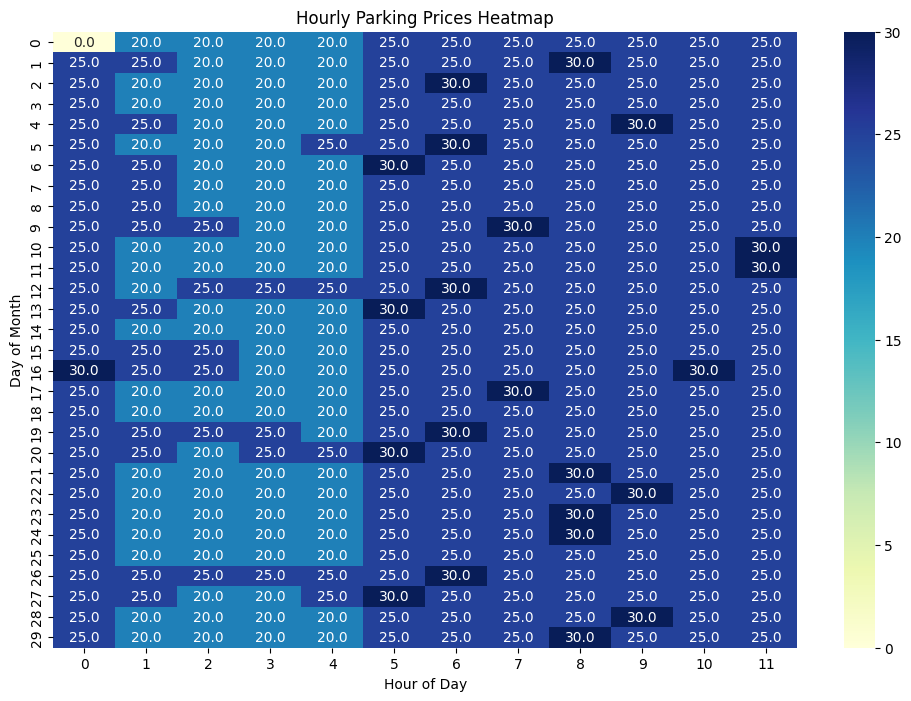

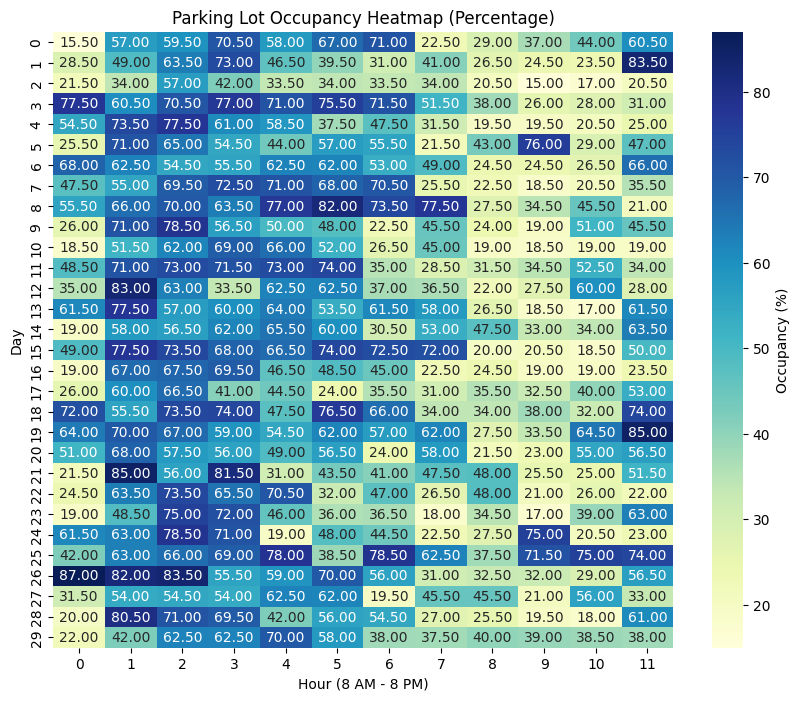

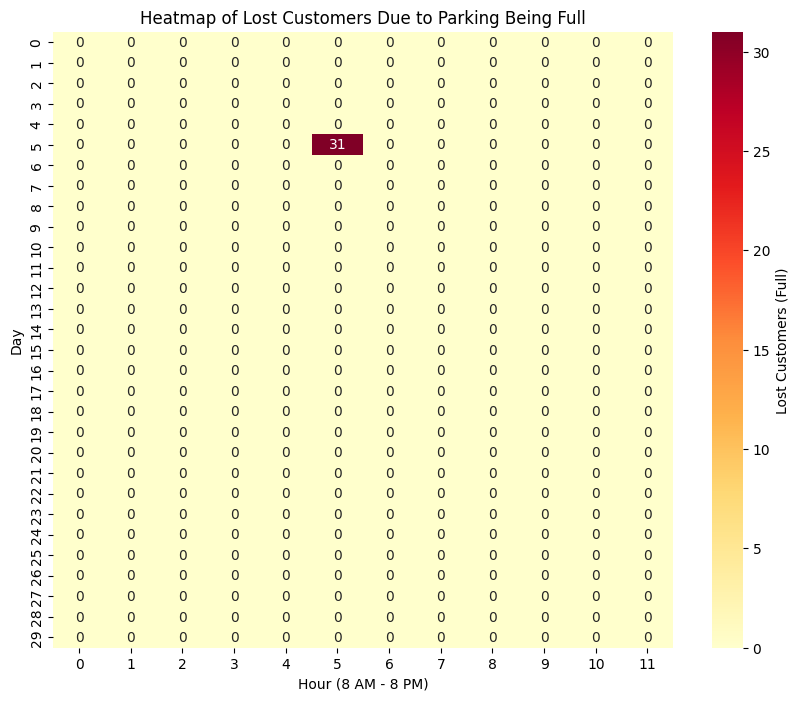

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
BASE_PRICE = 25
INITIAL_WILLINGNESS_TO_VISIT = 0.8  # Initial WTV for arrival rate
price_history = []  # List to track price changes over time

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15*3), (12, 17, 50*3), (17, 20, 50*3)],
    'Monday': [(8, 12, 15*3), (12, 17, 50*3), (17, 20, 50*3)],
    'Tuesday': [(8, 12, 15*3), (12, 17, 50*3), (17, 20, 50*3)],
    'Wednesday': [(8, 12, 15*3), (12, 17, 50*3), (17, 20, 50*3)],
    'Thursday': [(8, 12, 15*3), (12, 17, 50*3), (17, 20, 50*3)],
    'Friday': [(8, 12, 20*3), (12, 17, 70*3), (17, 20, 80*3)],
    'Saturday': [(8, 12, 20*3), (12, 17, 70*3), (17, 20, 80*3)]
}

# Initialize data for tracking prices, revenue, utilization, and lost customers
price_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
revenue_history_dynamic = np.zeros((30, 12))  # Revenue history for dynamic pricing
revenue_history_fixed = np.zeros((30, 12))  # Revenue history for fixed pricing
occupancy_history = np.zeros((30, 12))  # Occupancy history for each hour and day
lost_customers_full = np.zeros((30, 12))  # Lost customers due to parking full
lost_customers_due_to_wtv = np.zeros((30, 12))  # Lost customers due to WTV < 0.7
total_customers_attempted = np.zeros((30, 12))  # Total attempted customers
total_arrivals = np.zeros((30, 12))  # Total arrivals
total_parked_customers = np.zeros((30, 12))  # Total parked customers
lost_customers_due_to_dissatisfaction=np.zeros((30, 12))

# def update_wtv(price):
#     """Update willingness to visit based on price."""
#     global INITIAL_WILLINGNESS_TO_VISIT
#     price_coefficient = -1.2705
#     INITIAL_WILLINGNESS_TO_VISIT = max(0, min(1, INITIAL_WILLINGNESS_TO_VISIT + price_coefficient * (price - 25)))

def update_wtv(price):
    """Update willingness to visit based on price."""
    global INITIAL_WILLINGNESS_TO_VISIT
    price_coefficient = -1.2705  # Reduce the impact of price on WTV
    max_price_impact = -3  # Cap the reduction in WTV due to price increases
    
    # WTV decreases less drastically with higher prices
    price_impact = max(price_coefficient * (price - 25), max_price_impact)
    
    # Ensure WTV stays between 0.5 and 1
    INITIAL_WILLINGNESS_TO_VISIT = max(0.5, min(1, INITIAL_WILLINGNESS_TO_VISIT + price_impact))


def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def adjust_dynamic_pricing(env, parking_lot):
    """Adjust the parking price based on occupancy."""
    global BASE_PRICE, price_pattern
    
    while True:
        yield env.timeout(60)  # Check every hour
        current_time = env.now
        num_vehicles = len(parking_lot.users)
        occupancy = (num_vehicles / CAPACITY) * 100
        
        # Record the current parking price
        hour_index = (current_time // 60) % 12  # Convert minutes to simulation hour (0 to 11)
        day_index = (current_time // (12 * 60)) % 30  # Convert minutes to simulation day (0 to 29)
        
        if occupancy > 80:
            # Increase parking price to reduce arrivals
            BASE_PRICE = 30
        elif occupancy < 30:
            # Decrease parking price to increase arrivals
            BASE_PRICE = 20
        else:
            # Set price to base price if occupancy is within the range
            BASE_PRICE = 25
        
        update_wtv(BASE_PRICE)
        
        # Update WTV for the arrival rate
        price_pattern[day_index, hour_index] = BASE_PRICE

def vehicle(env, parking_lot, entry_price, day_index, hour_index):
    """Simulates a vehicle parking and tracks revenue."""
    global revenue_history_dynamic, revenue_history_fixed, lost_customers_due_to_wtv, total_parked_customers
    
    # Track the time of parking and the entry price
    arrival_time = env.now
    with parking_lot.request() as request:
        yield request
        if len(parking_lot.users) >= CAPACITY:
            # Increment the count of lost customers due to parking full
            lost_customers_full[day_index, hour_index] += 1
            return  # Exit the function as no parking is available
        parking_duration = np.random.exponential(60)  # Parking duration in minutes
        yield env.timeout(parking_duration)
        
        # Calculate the duration of stay
        duration_in_hours = parking_duration / 60
        if duration_in_hours <= 0.5:
            # Charge ₹15 for stays less than 30 minutes
            revenue = 15
        else:
            # Charge based on the hourly rate at the time of entry
            hours_rounded = np.ceil(duration_in_hours)
            revenue = hours_rounded * entry_price
        
        # # Determine if the customer shops and calculate WTV
        # shopping_done = np.random.exponential(5000)  # Mean spending of ₹5000, std deviation of ₹2000
        # satisfaction_wtv = max(0, min(1, -1.2705 * entry_price + (-0.00159 * shopping_done) + 115))

        if np.random.uniform() < 0.60:  # 60% probability to shop
            shopping_done = np.random.exponential(5000)  # Mean spending of ₹5000
            satisfaction_wtv = max(0, min(1, -1.2705 * entry_price + (-0.00159 * shopping_done) + 115))
             # Count lost customers due to WTV < 0.7
            if satisfaction_wtv < 0.7:
                lost_customers_due_to_wtv[day_index, hour_index] += 1
        # Track the revenue
        revenue_dynamic = revenue
        revenue_fixed = (parking_duration / 60) * BASE_PRICE  # Revenue for fixed pricing
        revenue_history_dynamic[day_index, hour_index] += revenue_dynamic
        revenue_history_fixed[day_index, hour_index] += revenue_fixed
        
       
        
        # Track parked customers
        total_parked_customers[day_index, hour_index] += 1

        # Update occupancy history
        occupancy = len(parking_lot.users) / CAPACITY * 100
        occupancy_history[day_index, hour_index] = occupancy

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    global lost_customers_full, total_customers_attempted, total_arrivals,lost_customers_due_to_dissatisfaction
    
    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours of the current day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)
        
        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range
        
        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                
                # Update the WTV for arrival
                update_wtv(BASE_PRICE)
                if np.random.uniform() > INITIAL_WILLINGNESS_TO_VISIT:
                    # Increment the count of lost customers due to parking full
                    lost_customers_due_to_dissatisfaction[day_index, hour_index] += 1
                else:
                    # Pass the current price to the vehicle process
                    env.process(vehicle(env, parking_lot, BASE_PRICE, day_index, hour_index))
                
                # Increment total attempted customers and total arrivals
                total_customers_attempted[day_index, hour_index] += 1
                total_arrivals[day_index, hour_index] += 1
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival
        else:
            print(f"Hour index {hour_index} is out of bounds for hour {current_hour}")

def run_simulation():
    """Runs the simulation for 30 days."""
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)
    
    # Start dynamic pricing adjustment process
    env.process(adjust_dynamic_pricing(env, parking_lot))

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

    # Calculate and print the results
    average_occupancy_morning = np.mean(total_parked_customers[:, 0:4], axis=1) / CAPACITY * 100  # 8-11:59 AM
    average_occupancy_afternoon = np.mean(total_parked_customers[:, 4:8], axis=1) / CAPACITY * 100  # 12-4:59 PM
    average_occupancy_evening = np.mean(total_parked_customers[:, 8:12], axis=1) / CAPACITY * 100  # 5-8 PM

    avg_occupancy_morning = np.mean(average_occupancy_morning)
    avg_occupancy_afternoon = np.mean(average_occupancy_afternoon)
    avg_occupancy_evening = np.mean(average_occupancy_evening)

    total_parked_customers_sum = np.sum(total_parked_customers)
    total_vehicles_simulated = np.sum(total_arrivals)
    total_revenue_dynamic = np.sum(revenue_history_dynamic)  # Adjust for dynamic pricing
    total_revenue_fixed = np.sum(revenue_history_fixed)  # Fixed pricing revenue
    
    percentage_lost_due_to_dissatisfaction = (np.sum(lost_customers_due_to_dissatisfaction) / total_vehicles_simulated) * 100
    percentage_lost_due_to_wtv = (np.sum(lost_customers_due_to_wtv) / total_vehicles_simulated) * 100
    percentage_lost_customers_due_to_full=(np.sum(lost_customers_full) / total_vehicles_simulated) * 100
    
    # Print results
    print(f"Average parking lot occupancy (8-11:59 AM): {avg_occupancy_morning:.2f}%")
    print(f"Average parking lot occupancy (12-4:59 PM): {avg_occupancy_afternoon:.2f}%")
    print(f"Average parking lot occupancy (5-8 PM): {avg_occupancy_evening:.2f}%")
    print(f"Total vehicles generated by simulation: {total_vehicles_simulated}")
    print(f"Total parked customers: {total_parked_customers_sum}")
    print(f"Total revenue (Dynamic Pricing): ₹{total_revenue_dynamic:.2f}")
    print(f"Total revenue (Fixed Pricing): ₹{total_revenue_fixed:.2f}")
    print(f"Total lost customers due to WTV < 0.7: {np.sum(lost_customers_due_to_wtv)}")
    print(f"Total lost customers due to parking full: {np.sum(lost_customers_full)}")
    print(f"Total lost customers due to parking full: {np.sum(percentage_lost_customers_due_to_full):.2f}%")
    print(f"Total lost customers due to parking dissatisfaction: {np.sum(lost_customers_due_to_dissatisfaction)}")
    print(f"Percentage of lost customers due to parking dissatisfaction: {percentage_lost_due_to_dissatisfaction:.2f}%")
    print(f"Percentage of lost customers due to WTV < 0.7: {percentage_lost_due_to_wtv:.2f}%")
    
    # Plot the heatmap for pricing
    plt.figure(figsize=(12, 8))
    sns.heatmap(price_pattern, annot=True, fmt='.1f', cmap='YlGnBu', cbar=True)
    plt.title('Hourly Parking Prices Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Month')
    plt.show()

# Generate a heatmap of parking lot occupancy
    plt.figure(figsize=(10, 8))
    sns.heatmap(occupancy_history, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Occupancy (%)'})
    plt.title("Parking Lot Occupancy Heatmap (Percentage)")
    plt.xlabel("Hour (8 AM - 8 PM)")
    plt.ylabel("Day")
    plt.show()

    # Generate a heatmap of lost customers due to parking being full
    plt.figure(figsize=(10, 8))
    sns.heatmap(lost_customers_full, cmap="YlOrRd", annot=True, fmt=".0f", cbar_kws={'label': 'Lost Customers (Full)'})
    plt.title("Heatmap of Lost Customers Due to Parking Being Full")
    plt.xlabel("Hour (8 AM - 8 PM)")
    plt.ylabel("Day")
    plt.show()
# Run the simulation
run_simulation()
